# Atlanta Forest Age Mapping - Fall 2025 Take-Home Project
## Starter Notebook Template

In [23]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from matplotlib.widgets import RectangleSelector

import os
from PIL import Image

os.makedirs("forests", exist_ok=True)
os.makedirs("non-forests", exist_ok=True)

# import rasterio
# from rasterio.plot import show

## Load Data

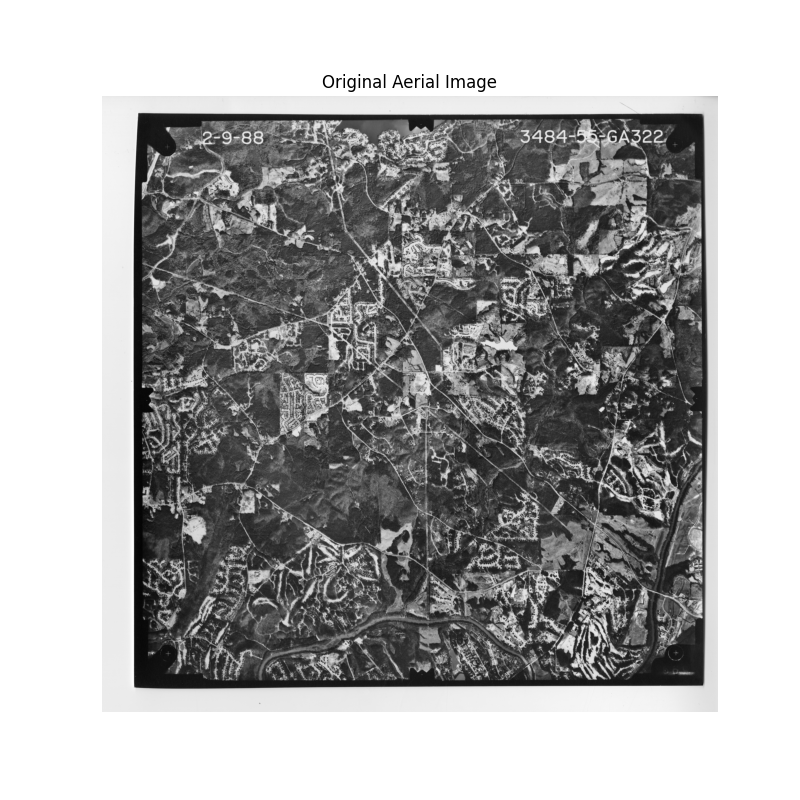

In [3]:
# Replace this with your own aerial imegery
'''
acceptingImg = True
print("Enter the image file directly (eg. atlanta-img.png)")
while(acceptingImg) {

}
'''

image_path = "images/fulton1.jpg"
img = cv2.imread(image_path)

# convert to rgb
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.title("Original Aerial Image")
plt.imshow(img_rgb)
plt.axis("off")
plt.show()


# Preprocessing

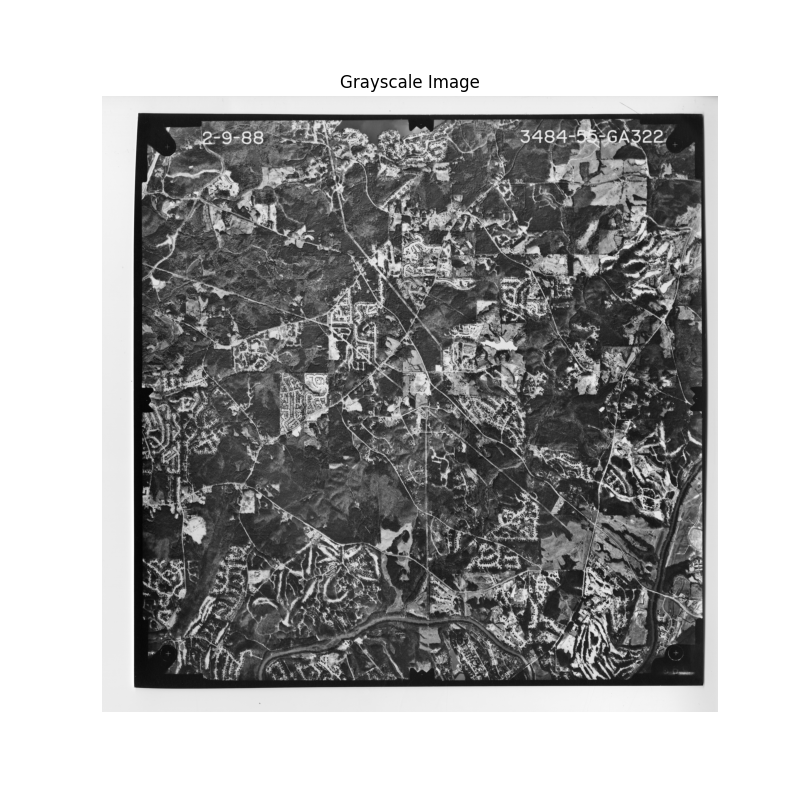

In [4]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 8))
plt.title("Grayscale Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.show()

# Add preprocessing steps here: blur, histogram equalization,...

# Baseline Forest Classification

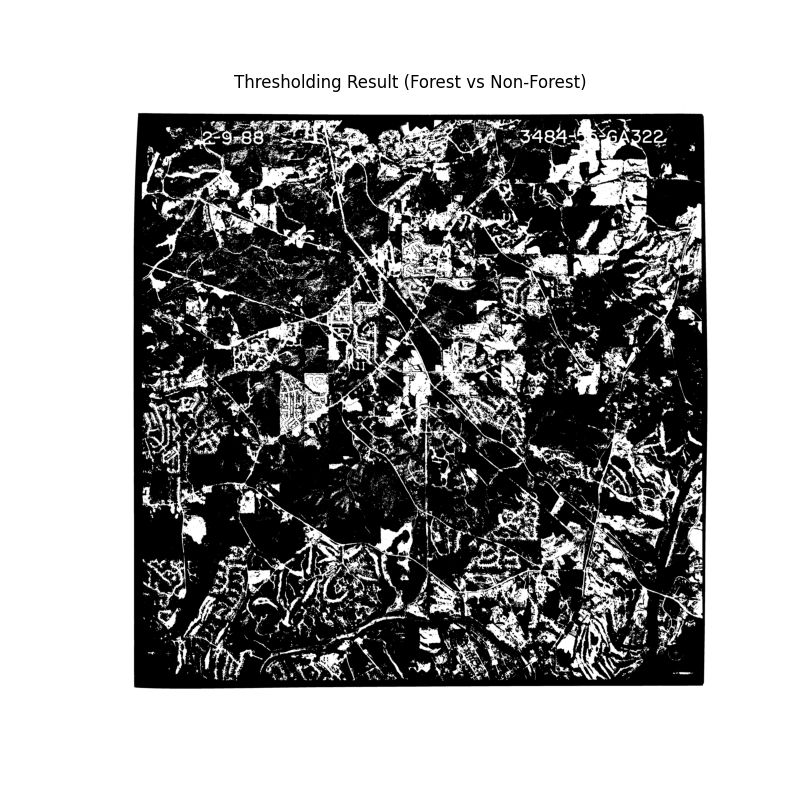

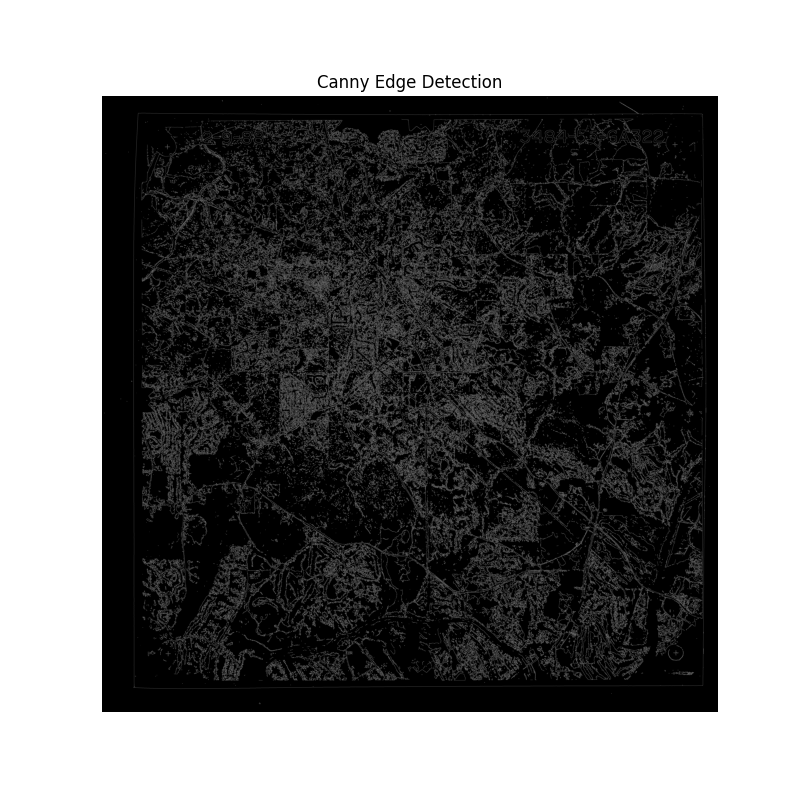

/Users/jiwonp2003/Documents/UGA_AI/Take_Home_Project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/jiwonp2003/Documents/UGA_AI/Take_Home_Project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/jiwonp2003/Documents/UGA_AI/Take_Home_Project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


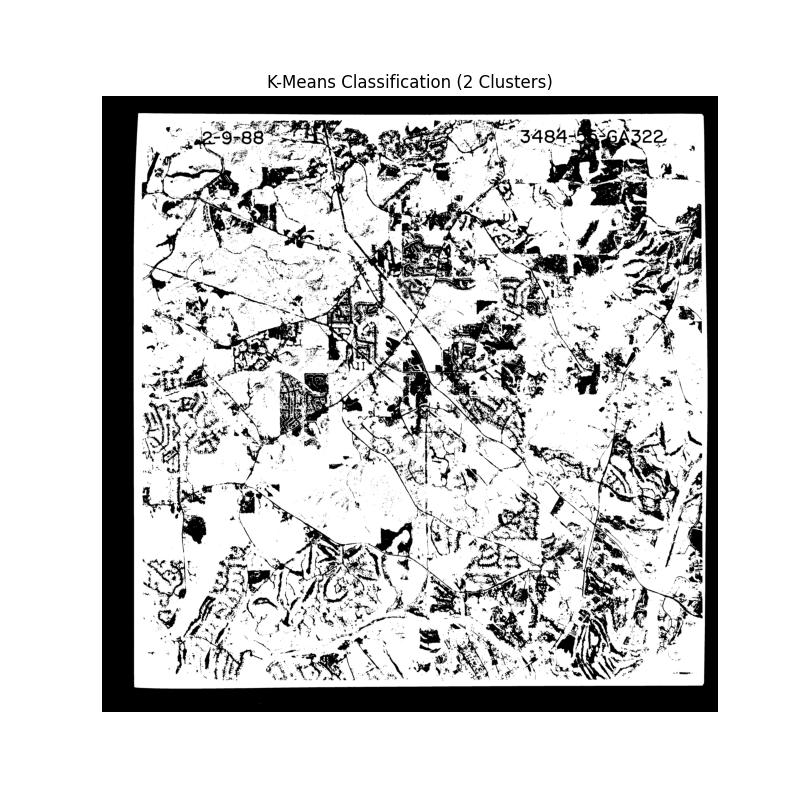

In [5]:
# Method 1: Thresholding 
# Simple global thresholding (should tweak values)
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(8, 8))
plt.title("Thresholding Result (Forest vs Non-Forest)")
plt.imshow(thresh, cmap="gray")
plt.axis("off")
plt.show()


# Method 2: Edge/Texture (Canny Edge Detection)
edges = cv2.Canny(gray, 100, 200)

plt.figure(figsize=(8, 8))
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap="gray")
plt.axis("off")
plt.show()


# Method 3: Clustering (K-Means on pixel intensity)
pixels = gray.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42).fit(pixels)
labels = kmeans.labels_.reshape(gray.shape)

plt.figure(figsize=(8, 8))
plt.title("K-Means Classification (2 Clusters)")
plt.imshow(labels, cmap="gray")
plt.axis("off")
plt.show()


# Machine Learning Classifier
Example: Train a simple classifier on pixel values
Create labels manually for a few points (forest vs non-forest)

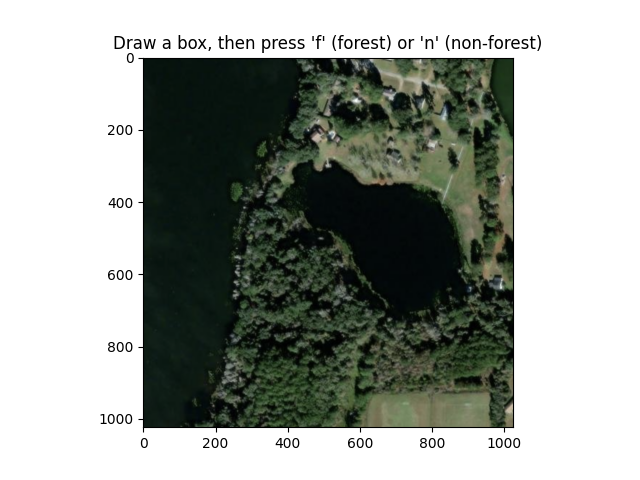

In [21]:
# Storage for labeled regions
labeled_regions = []  # list of (x1, y1, x2, y2, label)
current_box = None

def line_select_callback(eclick, erelease):
    """Triggered when a box is drawn."""
    global current_box
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    current_box = (x1, y1, x2, y2)
    print(f"Box drawn: ({x1}, {y1}) → ({x2}, {y2})")

def key_press_callback(event):
    """Triggered when a key is pressed."""
    global current_box, labeled_regions
    if current_box is not None:
        if event.key == "f":
            labeled_regions.append((*current_box, 1))
            ax.add_patch(plt.Rectangle((current_box[0], current_box[1]),
                                       current_box[2]-current_box[0],
                                       current_box[3]-current_box[1],
                                       fill=False, edgecolor="green", linewidth=2))
            print("Labeled as FOREST 🌳")
            current_box = None
            fig.canvas.draw()
        elif event.key == "n":
            labeled_regions.append((*current_box, 0))
            ax.add_patch(plt.Rectangle((current_box[0], current_box[1]),
                                       current_box[2]-current_box[0],
                                       current_box[3]-current_box[1],
                                       fill=False, edgecolor="red", linewidth=2))
            print("Labeled as NON-FOREST 🏙️")
            current_box = None
            fig.canvas.draw()

fig, ax = plt.subplots()

imgsample = cv2.imread("images/image6.png")

# convert to rgb
imgsample_rgb = cv2.cvtColor(imgsample, cv2.COLOR_BGR2RGB)
ax.imshow(imgsample_rgb)

rs = RectangleSelector(ax, line_select_callback, useblit=True, interactive=True, button=[1])
fig.canvas.mpl_connect("key_press_event", key_press_callback)

plt.title("Draw a box, then press 'f' (forest) or 'n' (non-forest)")
plt.show()

In [22]:
for i, (x1, y1, x2, y2, label) in enumerate(labeled_regions):
    # Crop the region
    region = imgsample_rgb[y1:y2, x1:x2]

    # Convert to PIL image
    patch_img = Image.fromarray(region)

    # Choose folder based on label
    if label == 1:
        save_path = f"forests/forest_{i}.png"
    else:
        save_path = f"non-forests/nonforest_{i}.png"

    # Save the patch
    patch_img.save(save_path)

print("✅ Saved labeled patches into 'forests/' and 'non-forests/' folders.")


✅ Saved labeled patches into 'forests/' and 'non-forests/' folders.


In [25]:
# Example: take pixels inside the first box
'''
x1, y1, x2, y2 = coords[0]
region = img_rgb[y1:y2, x1:x2]   # rows = y, cols = x
forest_samples = region.reshape(-1, 3)  # flatten to RGB pixels
'''


X, y = [], []
# Load forest patches
for filename in os.listdir("forests"):
    if filename.endswith(".png"):
        patch = np.array(Image.open(os.path.join("forests", filename)))
        pixels = patch.reshape(-1, 3)   # flatten into RGB vectors
        X.append(pixels)
        y.append(np.full(pixels.shape[0], 1))  # label = 1 for forest

# Load non-forest patches
for filename in os.listdir("non-forests"):
    if filename.endswith(".png"):
        patch = np.array(Image.open(os.path.join("non-forests", filename)))
        pixels = patch.reshape(-1, 3)
        X.append(pixels)
        y.append(np.full(pixels.shape[0], 0))  # label = 0 for non-forest

X = np.vstack(X)
y = np.concatenate(y)
# End of deviation



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred))

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91    127368
           1       0.91      0.93      0.92    141364

    accuracy                           0.91    268732
   macro avg       0.91      0.91      0.91    268732
weighted avg       0.91      0.91      0.91    268732

